In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.ai.vision.imageanalysis.models import VisualFeatures

from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

subscription_key = "5519e8e73e6a4eb5a82d40d17441b1c4"
endpoint = "https://ai-vision-yslandrei.cognitiveservices.azure.com/"
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

1. Sa se foloseasca un algoritm de clasificare a imaginilor (etapa de inferenta/testare) si sa se stabileasca performanta acestui algoritm de clasificare binara (imagini cu biciclete vs. imagini fara biciclete).

Processing images objects

In [2]:
real_is_bicycle_present = [True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
computed_is_bicycle_present = []

i = 0
for im_path in os.listdir("images/bikes"):
  img = open(f"images/bikes/{im_path}", "rb")
  result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
  
  IsBicyclePresent = False
  for obj in result.objects:
    if obj.object_property == 'bicycle' or obj.object_property == 'bike':
      IsBicyclePresent = True
      break

  computed_is_bicycle_present.append(IsBicyclePresent)
  print(f"{im_path} -> real: {real_is_bicycle_present[i]}, computed: {computed_is_bicycle_present[i]}")
  i += 1

bike01.jpg -> real: True, computed: True
bike02.jpg -> real: True, computed: True
bike03.jpg -> real: True, computed: True
bike04.jpg -> real: True, computed: True
bike05.jpg -> real: True, computed: True
bike06.jpg -> real: True, computed: False
bike07.jpg -> real: True, computed: True
bike08.jpg -> real: True, computed: False
bike09.jpg -> real: True, computed: True
bike10.jpg -> real: True, computed: True
traffic01.jpg -> real: False, computed: False
traffic02.jpg -> real: False, computed: False
traffic03.jpg -> real: False, computed: False
traffic04.jpg -> real: False, computed: False
traffic05.jpg -> real: False, computed: False
traffic06.jpg -> real: False, computed: False
traffic07.jpg -> real: False, computed: False
traffic08.jpg -> real: False, computed: False
traffic09.jpg -> real: False, computed: False
traffic10.jpg -> real: False, computed: False


Classification

In [3]:
def evalClassification(realLabels, computedLabels, labelNames):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
    
    cm = confusion_matrix(realLabels, computedLabels, labels = labelNames)
    acc = accuracy_score(realLabels, computedLabels)
    precision = precision_score(realLabels, computedLabels, average = None, labels = labelNames)
    recall = recall_score(realLabels, computedLabels, average = None, labels = labelNames)
    return acc, precision, recall 

acc, prec, recall = evalClassification(real_is_bicycle_present, computed_is_bicycle_present, [True, False])

print('acc: ', acc, ' precision: ', prec, ' recall: ', recall)

acc:  0.9  precision:  [1.         0.83333333]  recall:  [0.8 1. ]


2.a Pentru imaginile care contin biciclete sa se localizeze automat bicicletele in aceste imagini si sa se evidentieze chenarele care incadreaza bicicletele

Time wasted: 6 mins

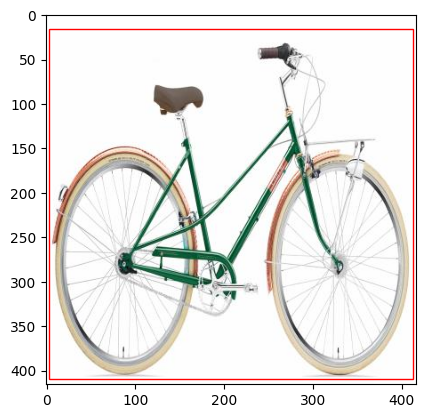

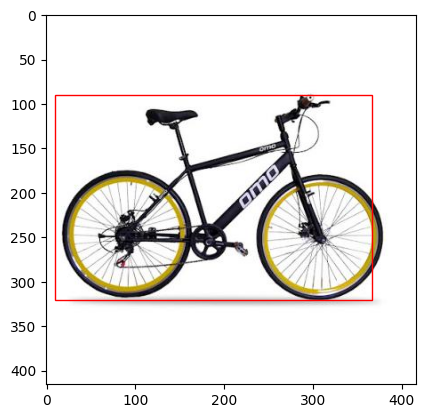

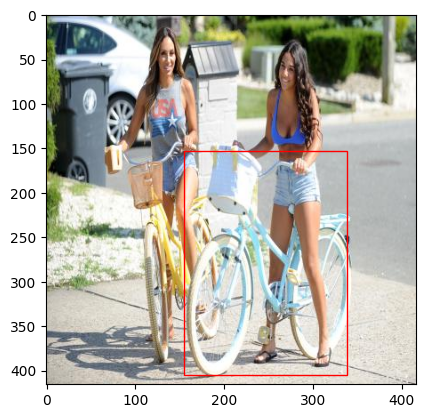

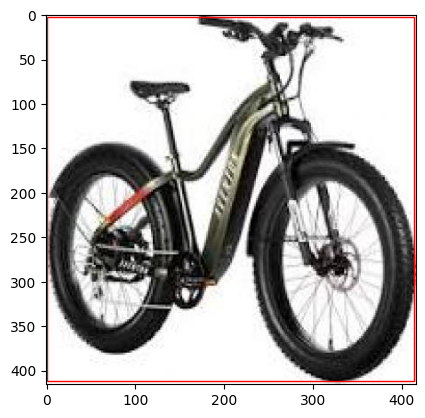

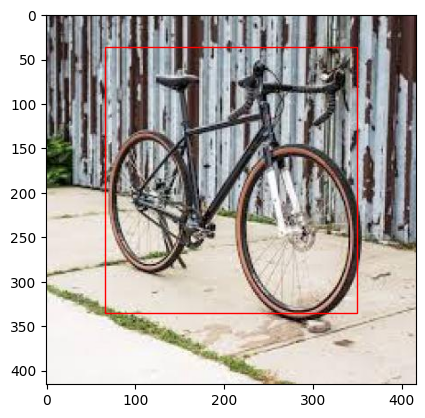

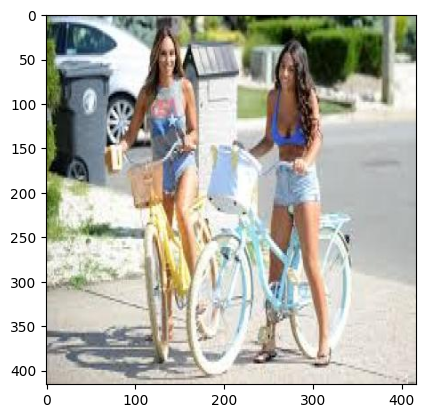

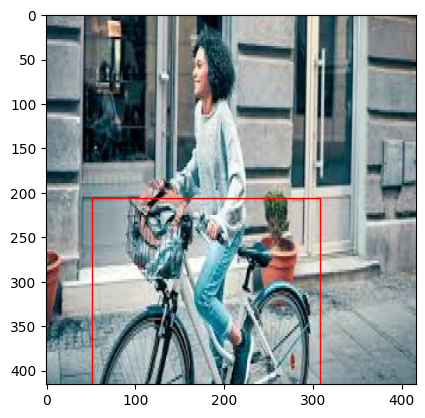

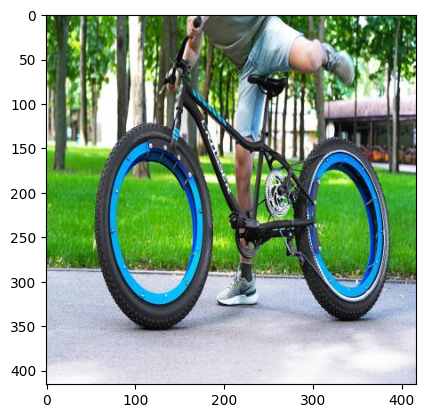

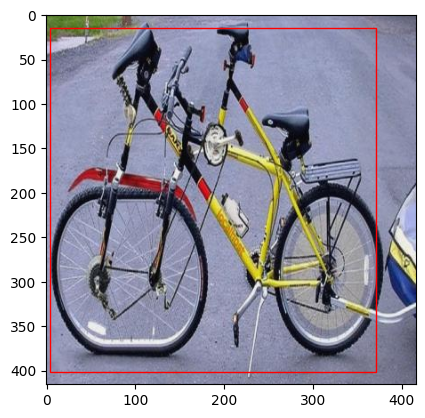

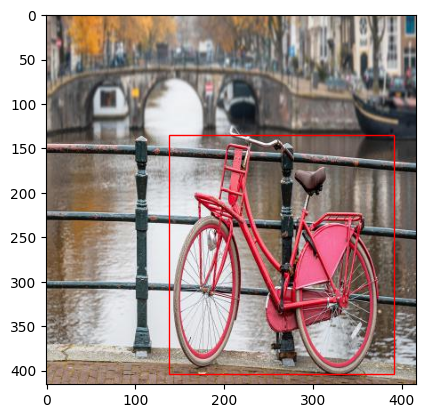

In [4]:
predicted_bikes_bb = []
for im_path in os.listdir("images/bikes"):
  if 'bike' not in im_path:
     continue
  img = open(f"images/bikes/{im_path}", "rb")
  result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
  predicted_bike_bb = []
  for ob in result.objects:
      if ob.object_property == "bicycle" or ob.object_property == "bike":
          predicted_bike_bb.append([ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h])
  predicted_bikes_bb.append(predicted_bike_bb)
  im = plt.imread(f"images/bikes/{im_path}")
  fig = plt.imshow(im)
  for bb in predicted_bike_bb:
    fig.axes.add_patch(plt.Rectangle(xy = (bb[0], bb[1]), width = bb[2]-bb[0], height = bb[3]-bb[1], fill = False, color = "red", linewidth = 1))
  plt.show()


2.b Pentru imaginile care contin biciclete sa se eticheteze (fara ajutorul algoritmilor de AI) aceste imagini cu chenare care sa incadreze cat mai exact bicicletele. Care task dureaza mai mult (cel de la punctul a sau cel de la punctul b)?

Time wasted: 19 mins

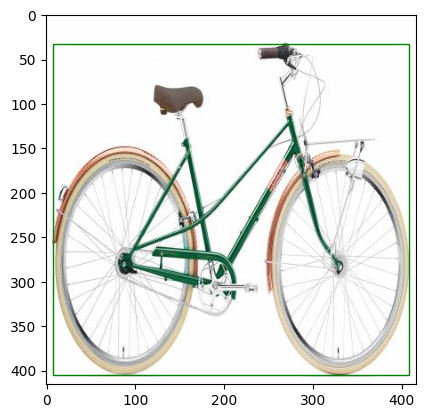

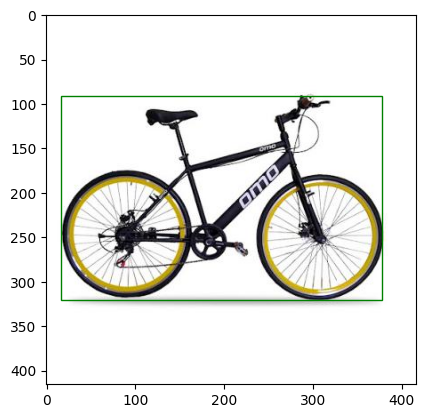

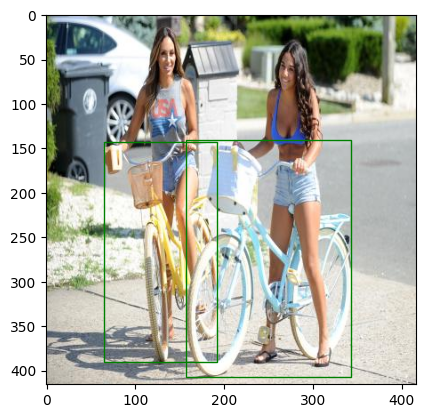

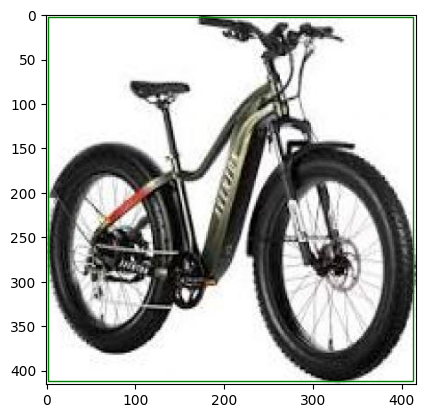

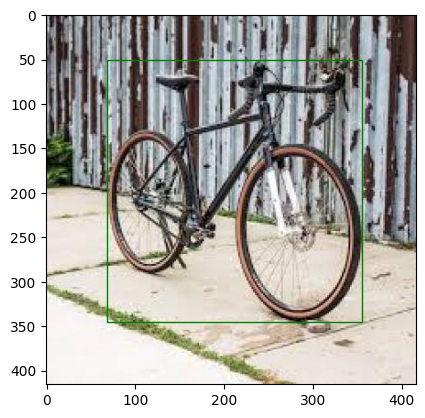

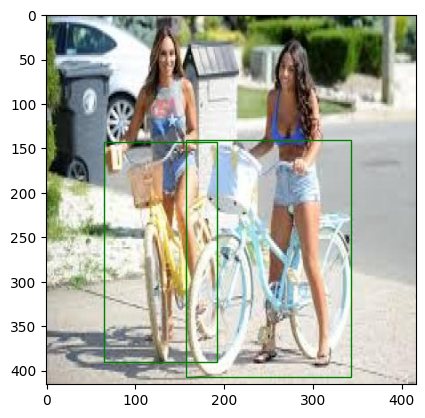

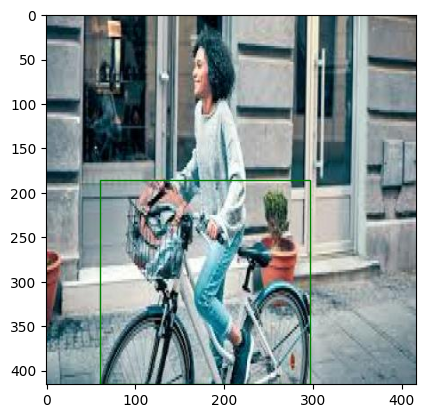

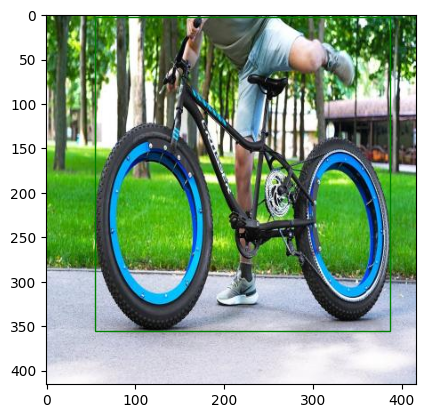

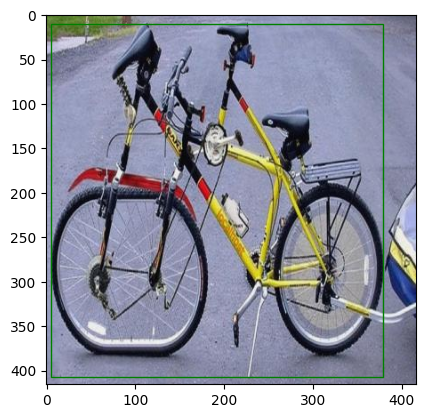

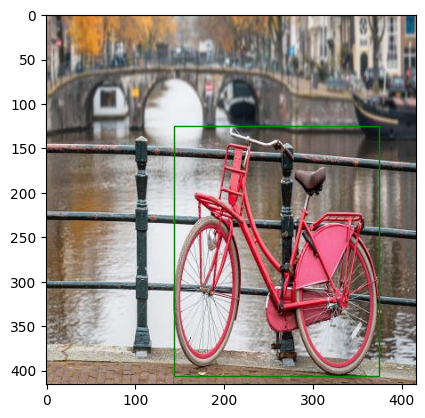

In [5]:
real_bikes_bb = [
   [[7, 32, 408, 405]],
   [[16, 91, 378, 321]],
   [[65, 143, 192, 390], [157, 141, 343, 407]],
   [[2, 2, 413, 412]],
   [[68, 50, 355, 345]],
   [[65, 143, 192, 390], [157, 141, 343, 407]],
   [[60, 186, 297, 415]],
   [[54, 2, 387, 355]],
   [[5, 10, 379, 407]],
   [[143, 125, 374, 406]]
]
i = 0
for im_path in os.listdir("images/bikes"):
  if 'bike' not in im_path:
     continue
  
  im = plt.imread(f"images/bikes/{im_path}")
  fig = plt.imshow(im)
  for bb in real_bikes_bb[i]:
    fig.axes.add_patch(plt.Rectangle(xy = (bb[0], bb[1]), width = bb[2]-bb[0], height = bb[3]-bb[1], color = 'green', fill = False, linewidth = 1))
  plt.show()
  i += 1

2.c Pentru imaginile care contin biciclete sa se determine performanta algoritmului de la punctul a avand in vedere etichetarile realizate la punctul b (se vor folosi cel putin 2 metrici).

bike01.jpg


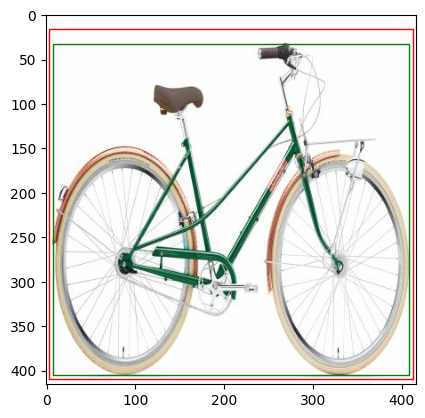

 - Bike 1
   - MAE: 7.25
   - RMSE: 78.25
   - IOU: 0.9283606051250386

bike02.jpg


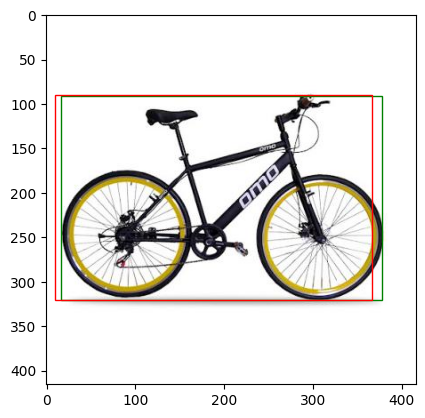

 - Bike 1
   - MAE: 5.0
   - RMSE: 48.5
   - IOU: 0.9446917089993941

bike03.jpg


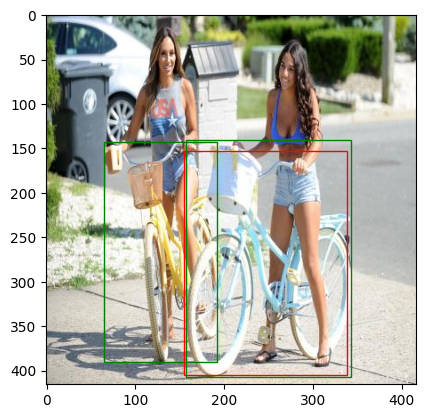

 - Bike 1
   - MAE: 65.25
   - RMSE: 7435.25
   - IOU: 0.13059550626696703

 - Bike 2
   - MAE: 262.0
   - RMSE: 81957.0
   - IOU: 0.0

bike04.jpg


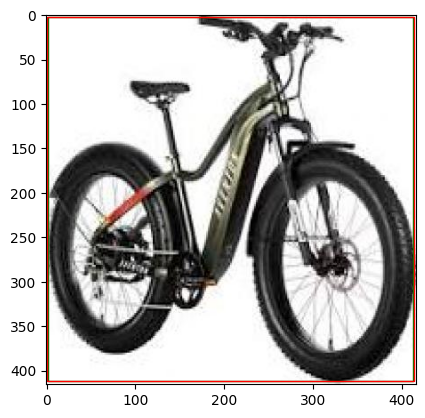

 - Bike 1
   - MAE: 0.75
   - RMSE: 1.25
   - IOU: 0.9927710843373494

bike05.jpg


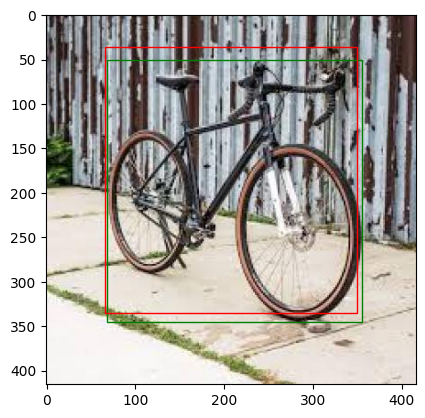

 - Bike 1
   - MAE: 8.0
   - RMSE: 84.0
   - IOU: 0.8981691834825605

bike06.jpg


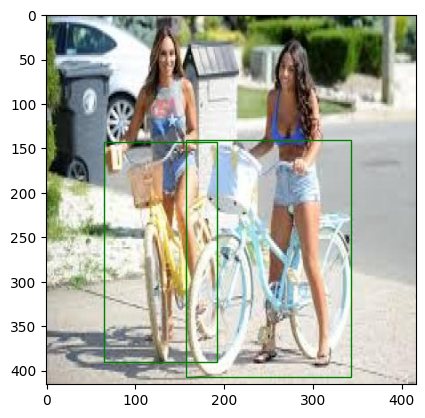

 - Bike 1
   - MAE: 197.5
   - RMSE: 53409.5
   - IOU: 0.0

 - Bike 2
   - MAE: 262.0
   - RMSE: 81957.0
   - IOU: 0.0

bike07.jpg


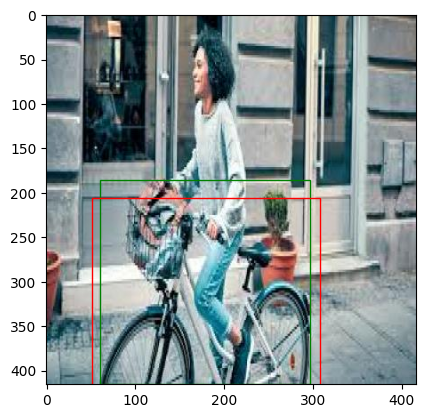

 - Bike 1
   - MAE: 10.25
   - RMSE: 150.75
   - IOU: 0.844285279908105

bike08.jpg


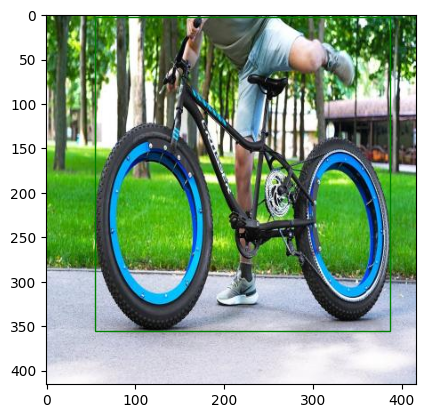

 - Bike 1
   - MAE: 199.5
   - RMSE: 69678.5
   - IOU: 0.0

bike09.jpg


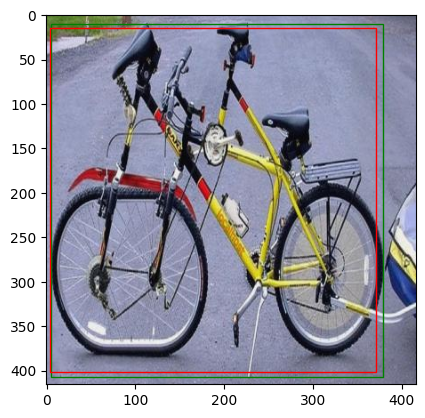

 - Bike 1
   - MAE: 4.5
   - RMSE: 26.5
   - IOU: 0.9540494122521536

bike10.jpg


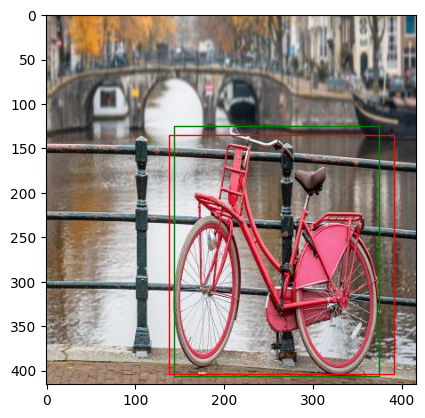

 - Bike 1
   - MAE: 8.5
   - RMSE: 104.5
   - IOU: 0.8777534891541954

[[[7, 32, 408, 405]], [[16, 91, 378, 321]], [[65, 143, 192, 390], [157, 141, 343, 407]], [[2, 2, 413, 412]], [[68, 50, 355, 345]], [[65, 143, 192, 390], [157, 141, 343, 407]], [[60, 186, 297, 415]], [[54, 2, 387, 355]], [[5, 10, 379, 407]], [[143, 125, 374, 406]]]
[[[3, 16, 412, 410]], [[9, 90, 366, 321]], [[155, 153, 338, 405]], [[0, 2, 414, 412]], [[66, 36, 349, 335]], [], [[51, 206, 308, 416]], [], [[4, 14, 371, 402]], [[138, 135, 391, 404]]]


In [6]:
def rmse(real_bb, computed_bb):
  err = 0
  for v in zip(real_bb, computed_bb):
      err = err + (v[0] - v[1])**2
  return err / len(real_bb)

def mae(real_bb, computed_bb):
  err = 0
  for v in zip(real_bb, computed_bb):
      err = err + abs(v[0] - v[1])
  return err / len(real_bb)

def iou(real_bb, computed_bb):
    x1_real, y1_real, x2_real, y2_real = real_bb
    x1_computed, y1_computed, x2_computed, y2_computed = computed_bb

    x1_intersection = max(x1_real, x1_computed)
    y1_intersection = max(y1_real, y1_computed)
    x2_intersection = min(x2_real, x2_computed)
    y2_intersection = min(y2_real, y2_computed)

    intersection_area = max(0, x2_intersection - x1_intersection + 1) * max(0, y2_intersection - y1_intersection + 1)

    area_real = (x2_real - x1_real + 1) * (y2_real - y1_real + 1)
    area_computed = (x2_computed - x1_computed + 1) * (y2_computed - y1_computed + 1)

    union_area = area_real + area_computed - intersection_area

    iou = intersection_area / union_area

    return iou

i = 0
for im_path in os.listdir("images/bikes"):
  if 'bike' not in im_path:
     continue
  
  im = plt.imread(f"images/bikes/{im_path}")
  print(im_path)
  fig = plt.imshow(im)
  for j in range(len(real_bikes_bb[i])):
    
    fig.axes.add_patch(plt.Rectangle(xy = (real_bikes_bb[i][j][0], real_bikes_bb[i][j][1]), width = real_bikes_bb[i][j][2]-real_bikes_bb[i][j][0], height = real_bikes_bb[i][j][3]-real_bikes_bb[i][j][1], color = 'green', fill = False, linewidth = 1))
    if j < len(predicted_bikes_bb[i]):
      fig.axes.add_patch(plt.Rectangle(xy = (predicted_bikes_bb[i][j][0], predicted_bikes_bb[i][j][1]), width = predicted_bikes_bb[i][j][2]-predicted_bikes_bb[i][j][0], height = predicted_bikes_bb[i][j][3]-predicted_bikes_bb[i][j][1], color = 'red', fill = False, linewidth = 1))
    
  plt.show()
    
  for j in range(len(real_bikes_bb[i])):
    print(" - Bike", j + 1)
    if j < len(predicted_bikes_bb[i]):
      print("   - MAE:", mae(real_bikes_bb[i][j], predicted_bikes_bb[i][j]))
      print("   - RMSE:", rmse(real_bikes_bb[i][j], predicted_bikes_bb[i][j]))
      print("   - IOU:", iou(real_bikes_bb[i][j], predicted_bikes_bb[i][j]))
    else:
      print("   - MAE:", mae(real_bikes_bb[i][j], [0, 0, 0, 0])) 
      print("   - RMSE:", rmse(real_bikes_bb[i][j], [0, 0, 0, 0]))
      print("   - IOU:", iou(real_bikes_bb[i][j], [0, 0, 0, 0]))

    print()
    
  i += 1

print(real_bikes_bb)
print(predicted_bikes_bb)